In [1]:
pip install tf-models-official

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow_probability 

Note: you may need to restart the kernel to use updated packages.


In [3]:
#@title Download and unzip the data. {display-mode:'form'}
#@markdown The data resides in the GitHub repository. For Hosted Runtime users, it is temporarily downloaded to the runtime's location.

from urllib.request import urlopen
from zipfile import ZipFile
zipurl = 'https://github.com/mtwenzel/parkinson-classification/raw/master/data/PPMI-classification.zip'
zipresp = urlopen(zipurl)
tempzip = open("PPMI-classification.zip", "wb")
tempzip.write(zipresp.read())
tempzip.close()
print("download complete, extracting...")

zf = ZipFile("PPMI-classification.zip")
zf.extractall(path = 'data/')
zf.close()
print("... done")

download complete, extracting...
... done


In [4]:
#@title Imports. {display-mode:'form'}
import pandas as pd
#from sklearn.metrics import confusion_matrix
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,GlobalAveragePooling2D,Flatten,concatenate,BatchNormalization, Dropout
from tensorflow.keras.applications import InceptionV3,DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import official.nlp.modeling.layers as nlp_layers
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
# Visualize the Train/Val loss
import matplotlib.pyplot as plt
%matplotlib inline

2023-08-25 10:49:46.138687: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-25 10:49:46.142269: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-25 10:49:46.203181: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-25 10:49:46.204879: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 10:49:47.354795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [5]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, 109, 91)
else:
    input_shape = (109, 91, 3)

In [6]:
#@title Set the data generators. {display-mode:'form', run: "auto"}
#@markdown Data augmentation choices. Cell runs automatically if anything is changed.
shear_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
zoom_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
width_shift_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
height_shift_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
rotation_range = 10 #@param {type:"slider", min:0, max:90, step:5}
horizontal_flip = True #@param {type:"boolean"}
vertical_flip = True #@param {type:"boolean"}
#@markdown Data source (No need to change if the download succeeded.)
train_directory = 'training_set/' #@param ['z:/Data/Parkinson_DATScans UKE/full_ppmi_data/png/', '/content/drive/My Drive/MEVIS/Data/PPMI-classification/'] {allow-input: true}
val_directory = 'val_set/'
test_directory = '/home/notebooks/sundar/data_UNSMOOTH/PPMI-classification' 
base_path = '/home/notebooks/sundar'

train_datagen = ImageDataGenerator(rescale=1./255,
                                   
    shear_range=shear_range,
    zoom_range=zoom_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    rotation_range=rotation_range,
    horizontal_flip=horizontal_flip,
    vertical_flip=vertical_flip)

train_generator = train_datagen.flow_from_directory(os.path.join(base_path,'training_set'), # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='sparse',
                                                    seed = 42,
                                                 shuffle=True
                                                    )

val_generator = train_datagen.flow_from_directory(os.path.join(base_path,'val_set'), # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='sparse',
                                                  seed = 42,
                                                 shuffle=True
                                                    )

# Data Generator for validation without data augmentation!
test_datagen   = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(os.path.join(test_directory, 'all_2d_val'), # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='sparse',
                                                  seed = 42,
                                                 shuffle=True)

Found 904 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 186 images belonging to 2 classes.


In [7]:
batch_size = 32
input_dim = 1024
num_classes = 2
kernel_size = 3

In [8]:
#@title Set the Model {display-mode:'form', run: "auto"}
#@markdown Model architecture choices. Cell runs automatically if anything is changed.
#spectral_norm = True#@param {type:"boolean"}
# utilising functional API to build cnn layers
inputs = Input(shape=input_shape)
y = Conv2D(filters=64,kernel_size=kernel_size,activation='relu')(inputs)
y = Conv2D(filters=64,kernel_size=kernel_size,activation='relu')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=96, kernel_size=kernel_size, activation='relu')(y)
y = Conv2D(filters=96, kernel_size=kernel_size, activation='relu')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=128, kernel_size=kernel_size, activation='relu')(y)
y = Conv2D(filters=128, kernel_size=kernel_size, activation='relu')(y)
y = MaxPooling2D()(y)

# convert image to vector 
y = Flatten()(y)
#spectral normalisation

fc0 = tf.keras.layers.Dense(128)
fcspect = nlp_layers.SpectralNormalization(fc0, norm_multiplier=0.9)(y)
#y = Dropout(0.25)(fcspect)
#y = tf.keras.layers.Dense(256, activation='relu')(fcspect)
#y = tf.keras.layers.Dropout(0.25)(y)
# else:
#   # dropout regularization
#   y = Dropout(0.25)(y)
#   y = tf.keras.layers.Dense(128, activation='relu')(y)
#   y = tf.keras.layers.Dropout(0.25)(y)
#fcspect = nlp_layers.SpectralNormalization(fc0, norm_multiplier=0.9)(fcspect)
#fcspect = nlp_layers.SpectralNormalization(fc0, norm_multiplier=0.9)(fcspect)
#output_layer1 = Dense(2 , activation='softmax')(fcspect)
# gp_layer = nlp_layers.RandomFeatureGaussianProcess(units=num_classes,
#                                                num_inducing=128,
#                                                normalize_input=False,
#                                                scale_random_features=True,
#                                                gp_cov_momentum=-1)
outputs = tf.keras.layers.Dense(1)(fcspect)
#outputs = (tf.keras.layers.Dense(units=1, activation='sigmoid'))(outputs)
#outputs = Dense(num_labels, activation='softmax')(y)
# model building by supplying inputs/outputs
model = Model(inputs=inputs, outputs=outputs)

2023-08-25 10:49:49.285464: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
import keras
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
custom_loss = keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(loss=custom_loss, 
              optimizer=optimizer, metrics=["accuracy"])

In [10]:
fit_config = dict(batch_size=128, epochs=100)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 109, 91, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 107, 89, 64)       1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 105, 87, 64)       36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 52, 43, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 41, 96)        55392     
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 39, 96)        83040     
                                                             

In [12]:
history = model.fit(train_generator,
                    **fit_config,
                    verbose=1,
                    validation_data=(val_generator))

Epoch 1/100
15/15 [==============================] - 22s 1s/step - loss: 0.6559 - accuracy: 0.4613 - val_loss: 0.6508 - val_accuracy: 0.3200
Epoch 2/100
15/15 [==============================] - 9s 566ms/step - loss: 0.6350 - accuracy: 0.5730 - val_loss: 0.6285 - val_accuracy: 0.6800
Epoch 3/100
15/15 [==============================] - 9s 573ms/step - loss: 0.6368 - accuracy: 0.5166 - val_loss: 0.6294 - val_accuracy: 0.6800
Epoch 4/100
15/15 [==============================] - 9s 592ms/step - loss: 0.6292 - accuracy: 0.6792 - val_loss: 0.6267 - val_accuracy: 0.6800
Epoch 5/100
15/15 [==============================] - 9s 587ms/step - loss: 0.6285 - accuracy: 0.6095 - val_loss: 0.6257 - val_accuracy: 0.6800
Epoch 6/100
15/15 [==============================] - 9s 570ms/step - loss: 0.6270 - accuracy: 0.6560 - val_loss: 0.6489 - val_accuracy: 0.3200
Epoch 7/100
15/15 [==============================] - 9s 563ms/step - loss: 0.6349 - accuracy: 0.5465 - val_loss: 0.6281 - val_accuracy: 0.6800
E

In [13]:
def predict_proba(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    return np.stack(preds).mean(axis=0)

def predict_class(X, model, num_samples):
    proba_preds = predict_proba(X, model, num_samples)
    return np.argmax(proba_preds, axis=1)


In [14]:
test_set = test_datagen.flow_from_directory(os.path.join(test_directory, 'all_2d_val'), # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=186,
                                                 seed = 42,
                                                 class_mode='binary',
                                                 shuffle=True)

Found 186 images belonging to 2 classes.


In [15]:
num_samples = 100

In [16]:
y_train, y_test = next(test_set)

In [17]:
y_test

array([1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
       0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

In [18]:
logits = predict_proba(y_train, model, num_samples)

In [19]:
logits.shape

(186, 1)

In [20]:
y_pred_logits = np.squeeze(logits)
y_pred_logits.shape

(186,)

In [21]:
y_test.shape

(186,)

In [22]:
def sigmoid(logits):
    return 1 / (1 + np.exp(-logits))

def logits_to_binary_predictions(logits, threshold=0.5):
    sigmoid_probs = sigmoid(logits)
    binary_predictions = (sigmoid_probs >= threshold).astype(int)
    return binary_predictions


In [23]:
y_prob_before_scaling = sigmoid(y_pred_logits)

In [24]:
predictions = logits_to_binary_predictions(logits)
predictions = np.squeeze(predictions)
predictions.shape

(186,)

In [25]:
# Temperature Scaling
temp = tf.Variable(initial_value=1.0, trainable=True, dtype=tf.float32)

def compute_loss():
    y_pred_model_w_temp = tf.math.divide(y_pred_logits, temp)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.convert_to_tensor(y_test), logits=y_pred_model_w_temp))
    return loss

optimizer = tf.optimizers.Adam(learning_rate=0.01)

print('Temperature Initial value: {}'.format(temp.numpy()))
for i in range(300):
    opts = optimizer.minimize(compute_loss, var_list=[temp])

print('Temperature Final value: {}'.format(temp.numpy()))

Temperature Initial value: 1.0
Temperature Final value: 0.7098106145858765


In [26]:
temp.shape

TensorShape([])

In [27]:
#New Logits by recommended method
y_pred_temp_final = tf.math.divide(y_pred_logits, temp)

In [28]:
y_pred_temp_final

<tf.Tensor: shape=(186,), dtype=float32, numpy=
array([  7.486681  ,   4.2002573 ,   6.106937  ,   5.7381797 ,
         4.93459   ,  -2.235951  ,   8.667318  ,  -5.6958084 ,
         8.862743  ,   6.844039  ,  -5.0961337 ,   2.343557  ,
         7.9659595 ,  -0.20062867,   4.2500696 ,  -0.7853478 ,
        10.925003  ,  -7.7705593 ,   4.203352  ,  -3.4356642 ,
        26.570608  ,  12.043392  ,   8.124966  ,   4.5835714 ,
        16.911263  ,  -4.3569956 ,   4.850282  ,   4.5083647 ,
        -6.7196894 ,   3.5601964 ,   2.2046041 ,   7.587232  ,
        -3.7126205 ,   5.571146  ,  -2.554379  ,   8.092105  ,
        21.101555  ,  -2.827019  ,   6.220464  ,   6.136099  ,
        26.64802   ,  -4.907575  ,  -2.6312237 ,  -5.3566194 ,
        -6.795553  ,  -6.908658  ,   5.6912084 ,   7.1311064 ,
         5.9861374 ,   1.9959282 , -10.375992  ,   1.2516085 ,
         3.9170516 ,   6.2560987 ,  -0.46324947,   9.216697  ,
        -6.666906  ,   4.6917133 ,   4.274289  ,   5.5393424 ,
       

In [29]:
predictions_from_calibrated_logits = logits_to_binary_predictions(y_pred_temp_final)
#predictions_from_calibrated_logits = np.squeeze(predictions_from_calibrated_logits)
predictions_from_calibrated_logits

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1])

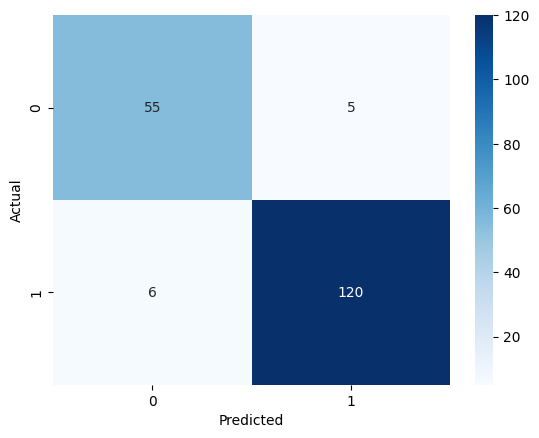

In [30]:
#import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



# Assuming you have a 1D array called 'predicted_labels' and a 1D array called 'actual_labels'
cm = confusion_matrix(y_test, predictions)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

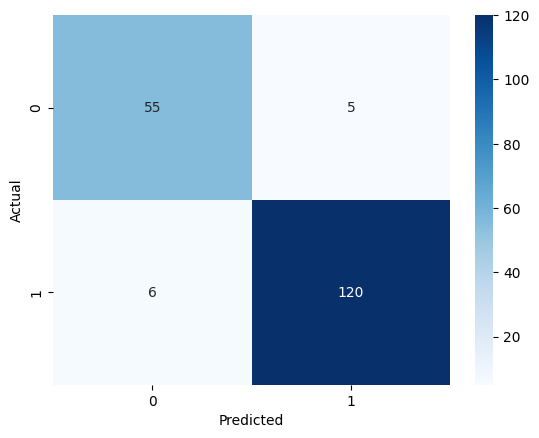

In [31]:
#import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



# Assuming you have a 1D array called 'predicted_labels' and a 1D array called 'actual_labels'
cm = confusion_matrix(y_test, predictions_from_calibrated_logits)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [32]:
y_pred_proba = sigmoid(y_pred_temp_final)

In [33]:
y_pred_proba.shape

(186,)

In [34]:
y_pred_proba_0 = 1 - y_pred_proba

# Create the 2D array with probabilities of class 0 and class 1
probability_matrix = np.column_stack((y_pred_proba_0, y_pred_proba))
probability_matrix.shape

(186, 2)

In [35]:
y_prob_before_scaling_0 = 1 - y_prob_before_scaling

# Create the 2D array with probabilities of class 0 and class 1
probability_matrix_before_scaling = np.column_stack((y_prob_before_scaling_0, y_prob_before_scaling))
probability_matrix_before_scaling.shape

(186, 2)

In [36]:

# calculate entropy for each row for DEEP ENSEMBLE
probs_array_before_scaling = np.array(probability_matrix_before_scaling)
entropy_before_scaling = -probs_array_before_scaling * np.log2(probs_array_before_scaling)
entropy_before_scaling = np.sum(entropy_before_scaling, axis=1)

# print the first 10 entropy values
print(entropy_before_scaling[:20])
entropy_before_scaling.shape

[0.04463021 0.27901894 0.09967832 0.12272745 0.19055407 0.6572289
 0.02192277 0.12566848 0.01945813 0.06517189 0.17471632 0.6326208
 0.03351476 0.9963521  0.27210143 0.9460646  0.00541227 0.03768035
 0.27858502 0.40313336]


/tmp/ipykernel_2150653/761283864.py:3: RuntimeWarning: divide by zero encountered in log2
  entropy_before_scaling = -probs_array_before_scaling * np.log2(probs_array_before_scaling)
/tmp/ipykernel_2150653/761283864.py:3: RuntimeWarning: invalid value encountered in multiply
  entropy_before_scaling = -probs_array_before_scaling * np.log2(probs_array_before_scaling)


(186,)

In [37]:
# calculate entropy for each row for DEEP ENSEMBLE
probs_array = np.array(probability_matrix)
entropy = -probs_array * np.log2(probs_array)
entropy = np.sum(entropy, axis=1)

# print the first 10 entropy values
print(entropy[:20])
entropy.shape

[6.85938308e-03 1.10971585e-01 2.27898099e-02 3.12157460e-02
 6.11858964e-02 4.58021730e-01 2.40076263e-03 3.23572382e-02
 2.01501721e-03 1.20484894e-02 5.35271131e-02 4.28337842e-01
 4.48873127e-03 9.92777467e-01 1.06658362e-01 8.96797061e-01
 3.09687370e-04 5.33728860e-03 1.10698782e-01 2.00370952e-01]


/tmp/ipykernel_2150653/1146629055.py:3: RuntimeWarning: divide by zero encountered in log2
  entropy = -probs_array * np.log2(probs_array)
/tmp/ipykernel_2150653/1146629055.py:3: RuntimeWarning: invalid value encountered in multiply
  entropy = -probs_array * np.log2(probs_array)


(186,)

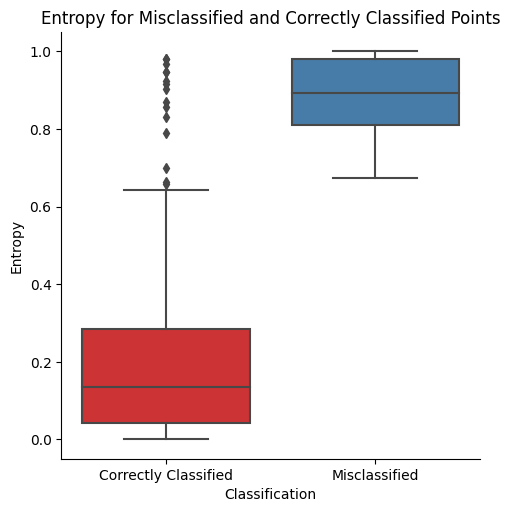

In [38]:
# Compare the predictions with the true values to find correctly classified and misclassified points
correctly_classified = predictions == y_test
misclassified = predictions != y_test

# Create a pandas DataFrame to organize the data for the plot
data_noclass_bs = pd.DataFrame({
    'Classification': ['Correctly Classified' if x else 'Misclassified' for x in correctly_classified],
    'Entropy': entropy_before_scaling
})

# Create the catplot using seaborn
sns.catplot(x='Classification', y='Entropy', data=data_noclass_bs, kind='box', palette='Set1')

# Set plot labels and title
plt.xlabel('Classification')
plt.ylabel('Entropy')
plt.title('Entropy for Misclassified and Correctly Classified Points')

# Show the plot
plt.show()

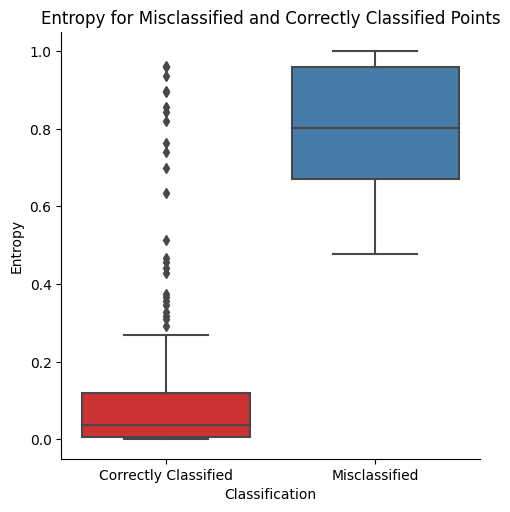

In [39]:
# Compare the predictions with the true values to find correctly classified and misclassified points
correctly_classified = predictions_from_calibrated_logits == y_test
misclassified = predictions_from_calibrated_logits != y_test

# Create a pandas DataFrame to organize the data for the plot
data_noclass = pd.DataFrame({
    'Classification': ['Correctly Classified' if x else 'Misclassified' for x in correctly_classified],
    'Entropy': entropy
})

# Create the catplot using seaborn
sns.catplot(x='Classification', y='Entropy', data=data_noclass, kind='box', palette='Set1')

# Set plot labels and title
plt.xlabel('Classification')
plt.ylabel('Entropy')
plt.title('Entropy for Misclassified and Correctly Classified Points')

# Show the plot
plt.show()

In [40]:
y_test_string = np.where(y_test, "PD", "HC")
y_test_string

array(['PD', 'PD', 'PD', 'PD', 'PD', 'HC', 'PD', 'HC', 'PD', 'PD', 'HC',
       'PD', 'PD', 'PD', 'PD', 'HC', 'PD', 'HC', 'PD', 'HC', 'PD', 'PD',
       'PD', 'PD', 'PD', 'HC', 'PD', 'PD', 'HC', 'PD', 'PD', 'PD', 'HC',
       'PD', 'HC', 'PD', 'PD', 'HC', 'PD', 'PD', 'PD', 'HC', 'HC', 'HC',
       'HC', 'HC', 'PD', 'PD', 'PD', 'HC', 'HC', 'PD', 'PD', 'PD', 'HC',
       'PD', 'HC', 'PD', 'PD', 'PD', 'PD', 'HC', 'PD', 'PD', 'PD', 'HC',
       'PD', 'HC', 'PD', 'PD', 'PD', 'HC', 'PD', 'PD', 'HC', 'HC', 'PD',
       'HC', 'HC', 'PD', 'PD', 'PD', 'PD', 'HC', 'PD', 'PD', 'HC', 'PD',
       'PD', 'PD', 'PD', 'PD', 'HC', 'PD', 'HC', 'HC', 'PD', 'PD', 'HC',
       'HC', 'PD', 'PD', 'PD', 'PD', 'HC', 'PD', 'PD', 'PD', 'PD', 'PD',
       'HC', 'PD', 'PD', 'PD', 'PD', 'PD', 'HC', 'HC', 'PD', 'PD', 'PD',
       'PD', 'PD', 'HC', 'PD', 'HC', 'HC', 'PD', 'PD', 'PD', 'HC', 'PD',
       'HC', 'HC', 'PD', 'PD', 'PD', 'PD', 'PD', 'PD', 'HC', 'HC', 'HC',
       'PD', 'PD', 'HC', 'PD', 'PD', 'PD', 'PD', 'P

In [41]:
data_pd = data_noclass.copy()
data_pd['Class'] = y_test_string

In [42]:
data_pd_bs = data_noclass_bs.copy()
data_pd_bs['Class'] = y_test_string

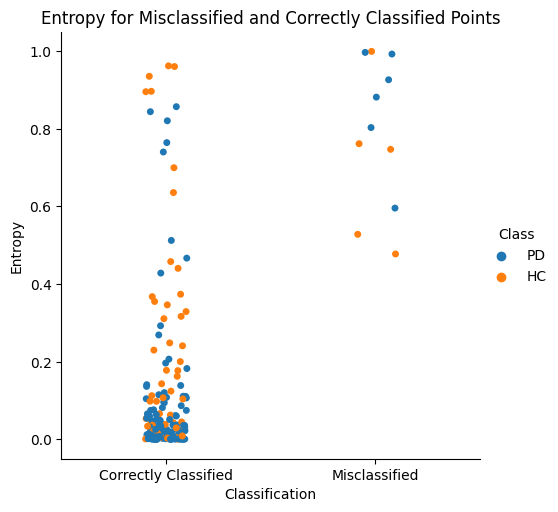

In [43]:

# Create the catplot using seaborn
sns.catplot(x='Classification', y='Entropy', data=data_pd, hue = 'Class')

# Set plot labels and title
plt.xlabel('Classification')
plt.ylabel('Entropy')
plt.title('Entropy for Misclassified and Correctly Classified Points')

# Show the plot
plt.show()

In [44]:
y_pred_logits.shape

(186,)

In [45]:
y_test.shape

(186,)

In [46]:
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32, name='labels_true')
y_pred_proba_tensor = tf.convert_to_tensor(y_pred_proba, dtype=tf.float32, name='logits')

In [47]:
y_test_tensor.shape

TensorShape([186])

In [48]:
y_pred_proba_tensor.shape

TensorShape([186])

In [49]:
y_test.shape

(186,)

In [50]:
y_pred_proba_before_scaling_0 = 1 - y_prob_before_scaling

# Create the 2D array with probabilities of class 0 and class 1
probability_matrix_before_scaling = np.column_stack((y_pred_proba_before_scaling_0, y_prob_before_scaling))
probability_matrix_before_scaling.shape

(186, 2)

In [51]:
#BEFORE SCALING
import tensorflow_probability as tfp

# Convert numpy arrays to TensorFlow tensors
y_proba_before_tensor = tf.convert_to_tensor(probability_matrix_before_scaling, dtype=tf.float32, name='probabilities')
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32, name='labels_true')
#y_pred_tensor = tf.convert_to_tensor(predictions_from_calibrated_logits, dtype=tf.int32, name='labels_true')

num_bins = 50
ece_result = tfp.stats.expected_calibration_error(num_bins=num_bins,
                                                  logits=y_proba_before_tensor,
                                                  labels_true=y_test_tensor)

print("Expected Calibration Error:", ece_result)

Expected Calibration Error: tf.Tensor(0.26198506, shape=(), dtype=float32)


In [52]:
# #AFTER SCALING
# # Apply temperature scaling to the logits
# y_pred_model_w_temp = tf.math.divide(y_pred_logits, temp)

# # Calculate the probabilities by applying the Sigmoid function
# y_pred_probabilities = tf.math.sigmoid(y_pred_model_w_temp)

# Convert numpy arrays to TensorFlow tensors
y_pred_proba_tensor = tf.convert_to_tensor(probability_matrix, dtype=tf.float32, name='probabilities')
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32, name='labels_true')
#y_pred_tensor = tf.convert_to_tensor(predictions_from_calibrated_logits, dtype=tf.int32, name='labels_true')

num_bins = 50
ece_result = tfp.stats.expected_calibration_error(num_bins=num_bins,
                                                  logits=y_pred_proba_tensor,
                                                  labels_true=y_test_tensor)

print("Expected Calibration Error:", ece_result)


Expected Calibration Error: tf.Tensor(0.26762363, shape=(), dtype=float32)


In [53]:
#FOR TEST SET
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n_samples = y_train.shape[0]
n_pixels = y_train.shape[1] * y_train.shape[2] * y_train.shape[3]
X = y_train.reshape(n_samples, n_pixels)

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Fit PCA model
pca = PCA(n_components=2)
pca.fit(X_std)

# Transform data to principal components
X_pca = pca.transform(X_std)

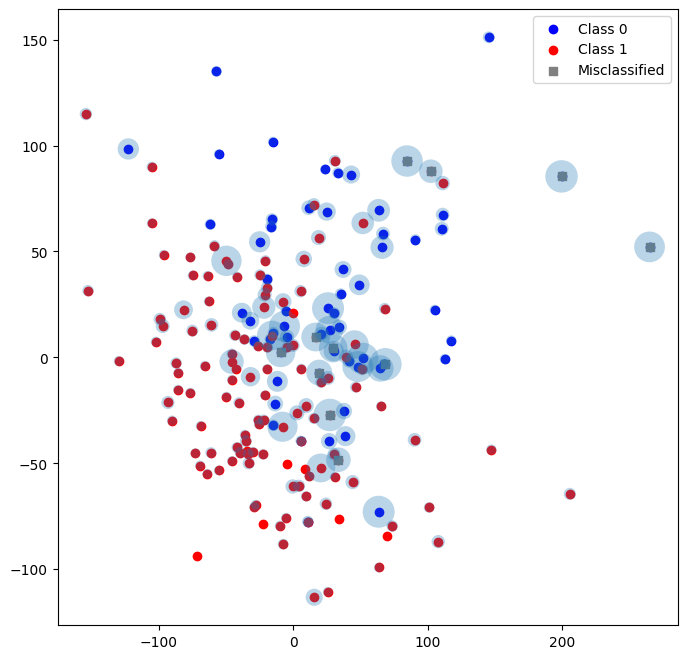

In [54]:
#@title Uncertainty Plot. {display-mode:'form', run: "auto"}
#@markdown Entropy, Predicted and True Value Plot

#@markdown Higher Entropy means higher uncertainty(INDICATED BY LARGER LIGHT BLUE MARKER AROUND THE POINTS)

transparency = 0.3 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
# from sklearn.decomposition import PCA
# Create x and y arrays from the PCA-transformed data
x = X_pca[:, 0]
y = X_pca[:, 1]

# Create arrays for uncertainty, predicted class, and true class
#uncertainty = ...  # shape (n_samples,)
#y_pred = ...  # shape (n_samples,)
colors = ['blue', 'red']  # Color for each class

# Create scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
for c in range(2):
    mask = predictions_from_calibrated_logits == c
    ax.scatter(x[mask], y[mask], c=colors[c], marker='o', label=f'Class {c}')
ax.scatter(x[y_test != predictions_from_calibrated_logits], y[y_test != predictions_from_calibrated_logits], c='gray', marker='s', label='Misclassified')
ax.legend()

# Add uncertainty as size of markers
sizes = 50 + 500 * entropy
ax.scatter(x, y, s=sizes, alpha=transparency, edgecolors='none')

plt.show()

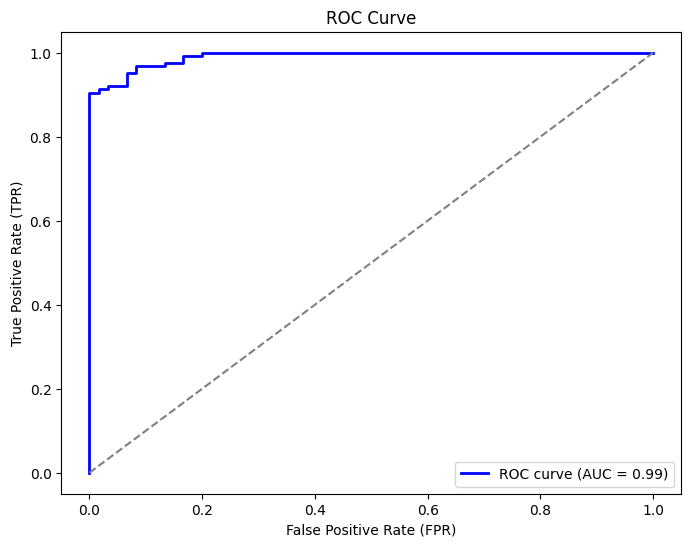

In [55]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have the true labels 'y_true' and predicted probabilities 'y_probs'
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [56]:
def expected_calibration_error(samples, true_labels, M=3):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

   # keep confidences / predicted "probabilities" as they are
    confidences = samples
    # get binary class predictions from confidences
    predicted_label = (samples>0.5).astype(float)

    # get a boolean list of correct/false predictions
    accuracies = predicted_label==true_labels

    ece_confidence = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prop_in_bin = in_bin.astype(float).mean()

        if prop_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].astype(float).mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece_confidence += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return ece_confidence

In [57]:
ece_value = expected_calibration_error(y_pred_proba, y_test)

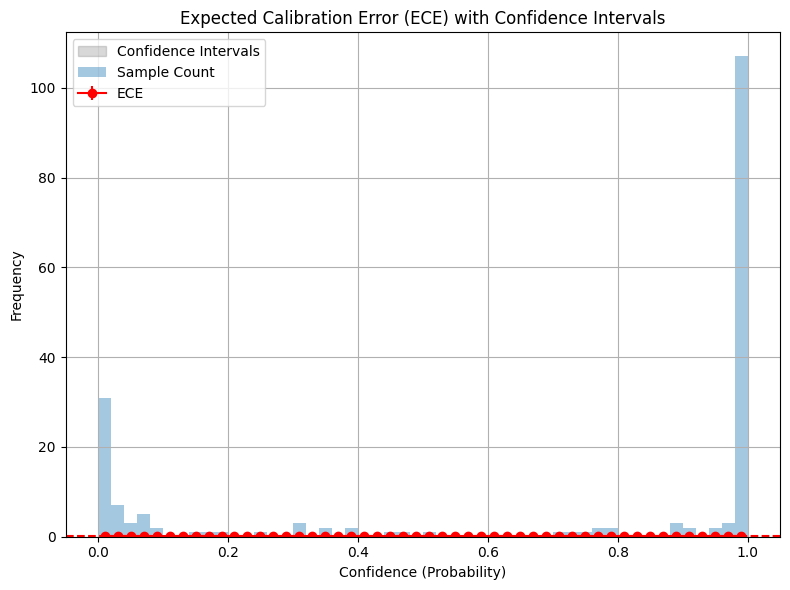

In [58]:
# Calculate the confidence intervals (you can use any desired confidence level)
confidence_level = 0.95
ece_mean = np.mean(ece_value)
ece_std = np.std(ece_value)
lower_confidence_bound = np.percentile(ece_value, (1 - confidence_level) * 100 / 2)
upper_confidence_bound = np.percentile(ece_value, 100 - (1 - confidence_level) * 100 / 2)

# Plot the ECE with confidence intervals
plt.figure(figsize=(8, 6))
bins = np.linspace(0, 1, num_bins + 1)
bin_lowers = bins[:-1]
bin_uppers = bins[1:]
bin_centers = bin_lowers + (bin_uppers - bin_lowers) / 2

plt.bar(bin_centers, np.histogram(y_pred_proba, bins=bins)[0], width=(bin_uppers - bin_lowers), alpha=0.4, label='Sample Count')
plt.errorbar(bin_centers, ece_mean * np.ones(num_bins), yerr=ece_std, linestyle='-', marker='o', label='ECE', color='red')
plt.axhline(y=ece_mean, linestyle='--', color='red')

# Plot the confidence intervals as shaded area
plt.fill_between(bin_centers, lower_confidence_bound, upper_confidence_bound, color='gray', alpha=0.3, label='Confidence Intervals')

plt.xlabel('Confidence (Probability)')
plt.ylabel('Frequency')
plt.title('Expected Calibration Error (ECE) with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

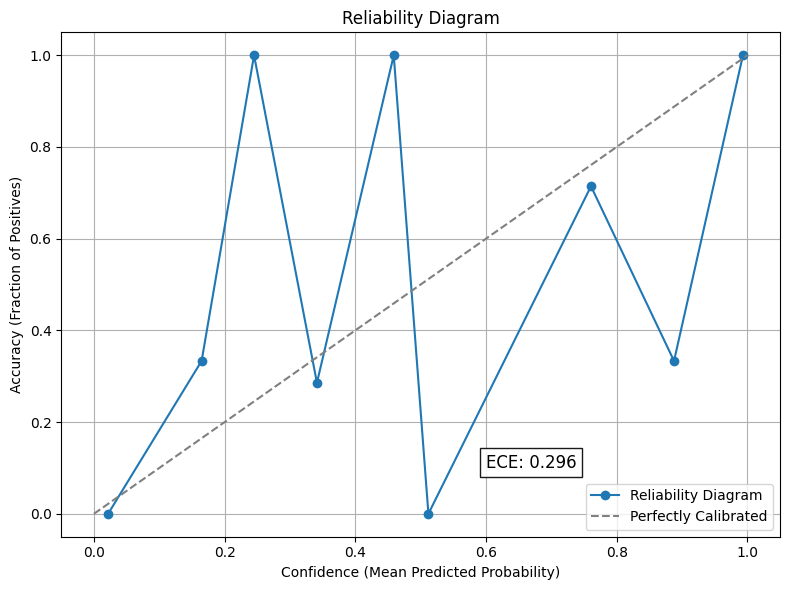

In [59]:
from sklearn.calibration import calibration_curve
num_bins = 10

# Calculate reliability diagram data
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=num_bins, strategy='uniform')

# Calculate the ECE
ece = np.mean(np.abs(prob_pred - prob_true))

# Plot the reliability diagram and ECE
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Reliability Diagram')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Confidence (Mean Predicted Probability)')
plt.ylabel('Accuracy (Fraction of Positives)')
plt.title('Reliability Diagram')
plt.legend()

# Display the ECE value in the plot
plt.text(0.6, 0.1, f'ECE: {ece:.3f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.9))

plt.grid(True)
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

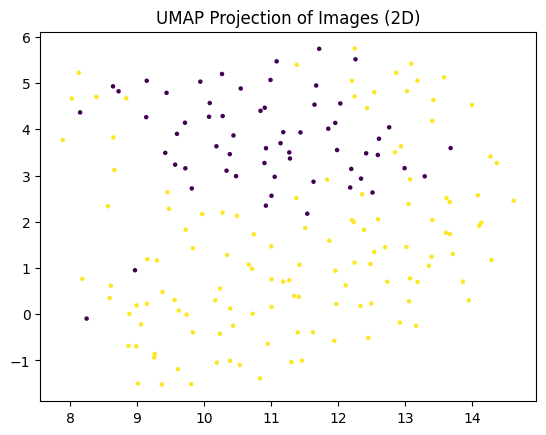

In [60]:
import umap.umap_ as umap 

# Create a UMAP model
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.6, n_components=2, random_state = 42)

# Fit and transform the data
umap_result = umap_model.fit_transform(X_std)

# Visualize the 2D points
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=y_test, cmap='viridis', s=5)
plt.title("UMAP Projection of Images (2D)")
plt.show()

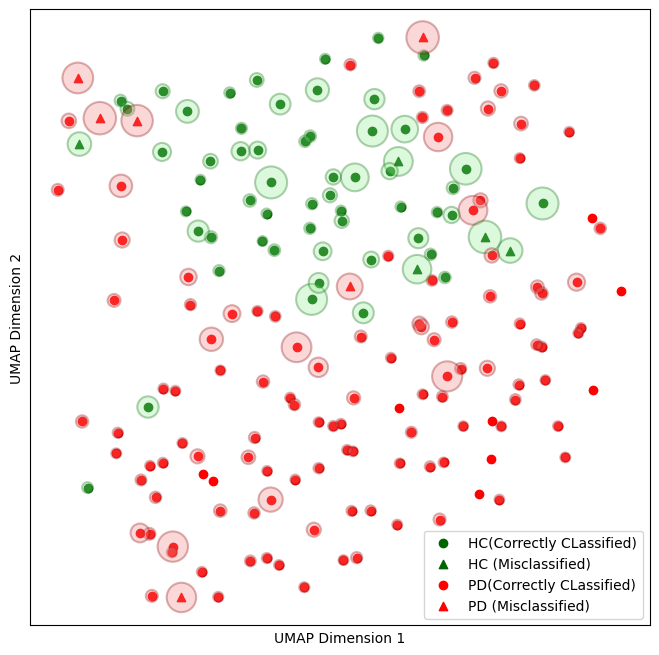

In [61]:
# Create x and y arrays from the t-SNE results
x = umap_result[:, 0]
y = umap_result[:, 1]

fig, ax = plt.subplots(figsize=(8, 8))

for c in range(2):
    mask = y_test == c  # Use ground truth labels for class mask
    
    # Correctly classified points as circles
    if c == 1:
        correct_mask = (y_test == predictions_from_calibrated_logits) & (y_test == 1)
        ax.scatter(x[correct_mask], y[correct_mask], marker='o', color='red', label='PD(Correctly CLassified)')
    else:
        correct_mask = (y_test == predictions_from_calibrated_logits) & (y_test == 0)
        ax.scatter(x[correct_mask], y[correct_mask], marker='o', color='darkgreen', label='HC(Correctly CLassified)')
    
    # Misclassified points as triangles
    misclassified_mask = (y_test != predictions_from_calibrated_logits) & (y_test == c)
    if c == 1:
        ax.scatter(x[misclassified_mask], y[misclassified_mask], marker='^', color='red', label='PD (Misclassified)')
    else:
        ax.scatter(x[misclassified_mask], y[misclassified_mask], marker='^', color='darkgreen', label='HC (Misclassified)')

# Add legend
ax.legend()

# Add uncertainty as size of markers
sizes = 50 + 500 * entropy  # Modify the sizes based on uncertainty
uncertainty_colors = np.where(y_test == 1,'lightcoral', 'lightgreen')
edge_colors = np.where(y_test == 1, 'darkred', 'darkgreen')  # Use 'darkgreen' and 'darkred' for edge colors
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')


ax.scatter(x, y, s=sizes, c=uncertainty_colors, alpha=transparency, edgecolor = edge_colors,  linewidths=1.5)

#Remove axes
ax.set_xticks([])
ax.set_yticks([])

plt.show()

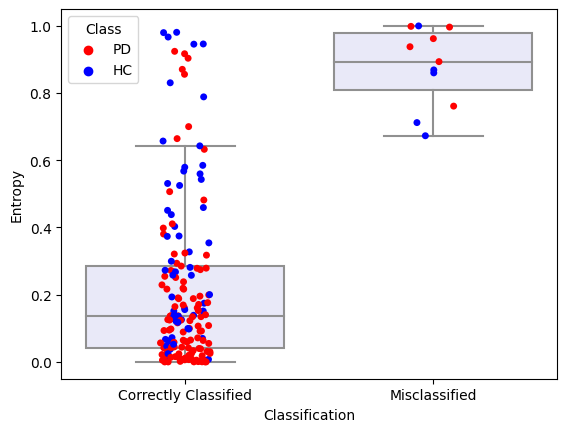

In [62]:
#BEFORE SCALING
box_color_palette = ['#E6E6FA','#E6E6FA']# colors=[lavender, lavender]
strip_color_palette = {'HC': '#0000FF', 'PD': '#FF0000'}# colors=[bright red, bright blue]
fig, ax = plt.subplots()
ax = sns.boxplot(x='Classification', y='Entropy', data=data_noclass_bs, palette=box_color_palette, showfliers=False)

sns.stripplot(x='Classification', y='Entropy', data=data_pd_bs, hue = 'Class', ax=ax, palette=strip_color_palette)
plt.show()


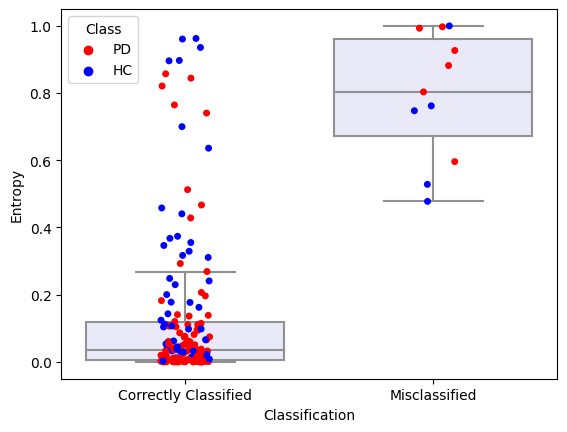

In [63]:
box_color_palette = ['#E6E6FA','#E6E6FA']# colors=[lavender, lavender]
strip_color_palette = {'HC': '#0000FF', 'PD': '#FF0000'}# colors=[bright red, bright blue]
fig, ax = plt.subplots()
ax = sns.boxplot(x='Classification', y='Entropy', data=data_noclass, palette=box_color_palette, showfliers=False)

sns.stripplot(x='Classification', y='Entropy', data=data_pd, hue = 'Class', ax=ax, palette=strip_color_palette)
plt.show()


In [64]:
# Step 1: Find Misclassified Point with Lowest Entropy
misclassified_points = data_pd[data_pd['Classification'] == 'Misclassified']
misclassified_points_sorted = misclassified_points.sort_values(by='Entropy', ascending=True)
lowest_entropy_misclassified = misclassified_points_sorted.iloc[0]

# Step 2: Use Lowest Entropy as Threshold
entropy_threshold = lowest_entropy_misclassified['Entropy']

# Step 3: Count Points Above Threshold
points_above_threshold = data_pd[data_pd['Entropy'] > entropy_threshold]

# Count Correctly Classified and Misclassified points above the threshold
correctly_classified_above_threshold = len(points_above_threshold[points_above_threshold['Classification'] == 'Correctly Classified'])
misclassified_above_threshold = len(points_above_threshold[points_above_threshold['Classification'] == 'Misclassified'])
total_above_threshold = correctly_classified_above_threshold + misclassified_above_threshold

# Display results
print(f"Lowest entropy misclassified point: {lowest_entropy_misclassified}")
print(f"Entropy threshold: {entropy_threshold}")
print(f"Number of Correctly Classified points above threshold: {correctly_classified_above_threshold}")
print(f"Number of Misclassified points above threshold: {misclassified_above_threshold}")
print(f"Total Number of samples above threshold: {total_above_threshold}")

Lowest entropy misclassified point: Classification    Misclassified
Entropy                0.477615
Class                        HC
Name: 83, dtype: object
Entropy threshold: 0.47761476039886475
Number of Correctly Classified points above threshold: 13
Number of Misclassified points above threshold: 10
Total Number of samples above threshold: 23


In [65]:
# Step 1: Preprocess Data 1 = Correctly Classified, 0 = misclassified
data_pd["Entropy"] = data_pd["Entropy"].fillna(0)
data_pd['Label'] = (data_pd['Classification'] == 'Correctly Classified').astype(int)
classification_array = data_pd['Label'].values
entropy_array  = data_pd['Entropy'].values

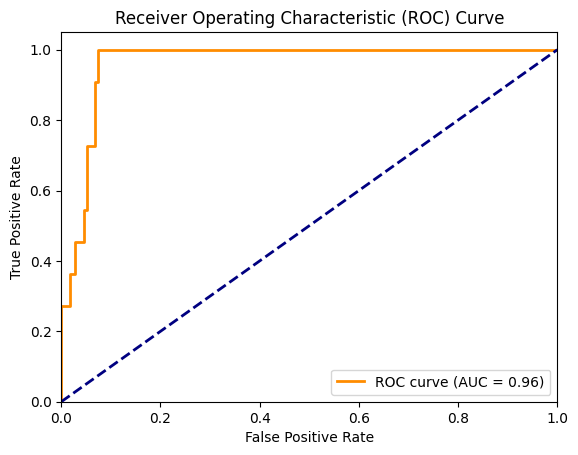

In [66]:
# Calculate true positive rate (sensitivity) and false positive rate for different thresholds
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(classification_array, entropy_array)
from sklearn.metrics import auc as sklearn_auc

# Calculate AUC
roc_auc = sklearn_auc(tpr, fpr)

# Plotting ROC curve
plt.figure()
plt.plot(tpr, fpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [67]:
data_pd

,Classification,Entropy,Class,Label
0,Correctly Classified,0.006859,PD,1
1,Correctly Classified,0.110972,PD,1
2,Correctly Classified,0.022790,PD,1
3,Correctly Classified,0.031216,PD,1
4,Correctly Classified,0.061186,PD,1
...,...,...,...,...
181,Correctly Classified,0.006683,PD,1
182,Correctly Classified,0.112448,HC,1
183,Correctly Classified,0.002974,PD,1
184,Correctly Classified,0.051836,PD,1


In [68]:
data_pd.to_csv('Model_entropy_data_csv/TempScale_model.csv')

In [69]:
# # Step 1: Preprocess Data 1 = Correctly Classified, 0 = misclassified
# data_pd['Label'] = (data_pd['Classification'] == 'Correctly Classified').astype(int)
# data_pd = data_pd.sort_values(by='Entropy', ascending=True)

# # Step 2: Calculate True Positive Rate and False Positive Rate
# tpr = data_pd['Label'].cumsum() / data_pd['Label'].sum()  # True Positive Rate (Sensitivity)
# fpr = (data_pd['Label'] == 0).cumsum() / (data_pd['Label'] == 0).sum()  # False Positive Rate (1-Specificity)

# from sklearn.metrics import auc as sklearn_auc

# roc_auc = sklearn_auc(fpr, tpr)

# # Step 3: Plot the Curve
# plt.figure(figsize=(6, 6))
# plt.plot(fpr, tpr, marker='o', color='b', label=f'ROC-like Curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC-like Curve')
# plt.legend()
# plt.grid(True)
# plt.show()